In [1]:
import pandas as pd
import janitor
from utilities import calculate_summary_statistics, pandas_to_tex, save_mpl_fig

import warnings

warnings.filterwarnings("ignore")
from matplotlib.lines import Line2D

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats.mstats import winsorize
import statsmodels.api as sm
from scipy.stats import percentileofscore
from IPython.display import display
from scipy.stats.mstats import winsorize
import statsmodels.api as sm
sns.set_theme(context="notebook", font_scale=1.35, style="whitegrid", palette="dark")

## Prep

In [2]:
df = (
    pd.read_csv("../data/6.3m-ind-domain-data.csv.gz")
    .rename_column("visit_duration", "duration")
    .assign(
        duration_min=lambda df_: df_["duration"] / 60,
        duration_hr=lambda df_: df_["duration"] / 3600,
    )
    # ==================================================
    # Merge to VT
    .merge(
        (pd.read_csv("../data/yg_virustotal_dat.csv")),
        how="left",
        left_on="private_domain",
        right_on="filename",
        validate="m:1",
    )
    .assign(
        malicious_bool=lambda df_: np.where(df_["malicious"] >= 2, True, False),
        malicious_min=lambda df_: df_["malicious_bool"] * df_["duration_min"],
        malicious_hr=lambda df_: df_["malicious_bool"] * df_["duration_hr"],
        suspicious_bool=lambda df_: df_["suspicious"].astype("bool"),
    )
    # ==================================================
    # Merge to ind demo (n = 1200)
    .merge(
        (
            pd.read_csv("../data/profile.csv").assign(
                # https://github.com/themains/bad_domains/blob/main/data/codebook.pdf
                gender_lab=lambda df_: df_["gender"].replace({1: "Male", 2: "Female"}),
                race_lab=lambda df_: df_["race"].replace(
                    {
                        1: "White",
                        2: "Black",
                        3: "Hispanic",
                        4: "Asian",
                        5: "Other",
                        6: "Other",
                        7: "Other",
                        8: "Other",
                    }
                ),
                educ_lab=lambda df_: df_["educ"].replace(
                    {
                        1: "HS or Below",
                        2: "HS or Below",
                        3: "Some college",
                        4: "Some college",
                        5: "College",
                        6: "Postgrad",
                    }
                ),
                agegroup_lab=lambda df_: pd.cut(
                    df_["birthyr"],
                    # early baby boomers
                    # late baby boomers/ early genX
                    # genX, early millenials
                    # millenials
                    # genZ
                    bins=[1930, 1957, 1972, 1987, 1997, 2003],
                    labels=["65+", "50--65", "35--50", "25--35", "<25"],
                ),
            )
        ),
        how="left",
        on="caseid",
        validate="m:1",
    )
)
display(df.head())
df.info()

,caseid,private_domain,category,visit_time_local,duration,duration_min,duration_hr,filename,harmless,malicious,...,educ,pid3,pid7,presvote20post,inputstate,region,gender_lab,race_lab,educ_lab,agegroup_lab
0,205323077,google.com,Search Engines and Portals,2022-05-31 23:52:37,2,0.033333,0.000556,google.com,70.0,0.0,...,3,2,7,2,45,3,Male,White,Some college,50--65
1,205323077,coupons.com,"Business, Shopping",2022-06-01 01:07:35,457,7.616667,0.126944,coupons.com,68.0,0.0,...,3,2,7,2,45,3,Male,White,Some college,50--65
2,205323077,google.com,Business,2022-06-01 01:15:12,55,0.916667,0.015278,google.com,70.0,0.0,...,3,2,7,2,45,3,Male,White,Some college,50--65
3,205323077,coupons.com,"Business, Shopping",2022-06-01 01:16:07,2225,37.083333,0.618056,coupons.com,68.0,0.0,...,3,2,7,2,45,3,Male,White,Some college,50--65
4,205323077,google.com,Search Engines and Portals,2022-06-01 04:38:10,10,0.166667,0.002778,google.com,70.0,0.0,...,3,2,7,2,45,3,Male,White,Some college,50--65


<class 'pandas.core.frame.DataFrame'>
Int64Index: 6297382 entries, 0 to 6297381
Data columns (total 35 columns):
 #   Column            Dtype   
---  ------            -----   
 0   caseid            int64   
 1   private_domain    object  
 2   category          object  
 3   visit_time_local  object  
 4   duration          int64   
 5   duration_min      float64 
 6   duration_hr       float64 
 7   filename          object  
 8   harmless          float64 
 9   malicious         float64 
 10  suspicious        float64 
 11  undetected        float64 
 12  timeout           float64 
 13  forcepoint        object  
 14  sophos            object  
 15  bitdefender       object  
 16  comodo            object  
 17  alphamnt          object  
 18  malicious_bool    bool    
 19  malicious_min     float64 
 20  malicious_hr      float64 
 21  suspicious_bool   bool    
 22  birthyr           float64 
 23  gender            int64   
 24  race              int64   
 25  educ              

In [3]:
df_mal_visits = df.query("malicious>0").reset_index(drop=True)
# assert (df_mal_visits["duration_min"] == df_mal_visits["malicious_min"]).all()
display(df_mal_visits.head(3))
df_mal_visits.info()

,caseid,private_domain,category,visit_time_local,duration,duration_min,duration_hr,filename,harmless,malicious,...,educ,pid3,pid7,presvote20post,inputstate,region,gender_lab,race_lab,educ_lab,agegroup_lab
0,205323077,gmail.co,NaN,2022-06-11 18:24:08,1,0.016667,0.000278,gmail.co,66.0,1.0,...,3,2,7,2,45,3,Male,White,Some college,50--65
1,205323077,gmail.com,Chat and Instant Messaging,2022-06-11 18:24:09,6,0.100000,0.001667,gmail.com,69.0,1.0,...,3,2,7,2,45,3,Male,White,Some college,50--65
2,205323077,aboutamazon.com,Business,2022-06-13 12:19:13,271,4.516667,0.075278,aboutamazon.com,68.0,1.0,...,3,2,7,2,45,3,Male,White,Some college,50--65


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 155671 entries, 0 to 155670
Data columns (total 35 columns):
 #   Column            Non-Null Count   Dtype   
---  ------            --------------   -----   
 0   caseid            155671 non-null  int64   
 1   private_domain    155671 non-null  object  
 2   category          108472 non-null  object  
 3   visit_time_local  155671 non-null  object  
 4   duration          155671 non-null  int64   
 5   duration_min      155671 non-null  float64 
 6   duration_hr       155671 non-null  float64 
 7   filename          155671 non-null  object  
 8   harmless          155671 non-null  float64 
 9   malicious         155671 non-null  float64 
 10  suspicious        155671 non-null  float64 
 11  undetected        155671 non-null  float64 
 12  timeout           155671 non-null  float64 
 13  forcepoint        142127 non-null  object  
 14  sophos            121894 non-null  object  
 15  bitdefender       96754 non-null   object  
 16  co

In [4]:
df_mal_visits['duration'].describe(percentiles=[.1,.2,.3,.4,.5,.6,.7,.8,.9,.95,.96,.97,.98,.99])

count    155671.000000
mean         62.516320
std         820.910973
min           0.000000
10%           1.000000
20%           1.000000
30%           2.000000
40%           3.000000
50%           5.000000
60%           8.000000
70%          12.000000
80%          23.000000
90%          62.000000
95%         180.000000
96%         240.000000
97%         319.000000
98%         454.000000
99%         660.000000
max       85621.000000
Name: duration, dtype: float64

In [5]:
df_mal_visits.query("duration<=1")["malicious"].describe(percentiles=[.5,.6,.7,.8,.9,.95,.96,.97,.98,.99])

count    40054.000000
mean         1.405153
std          1.257412
min          1.000000
50%          1.000000
60%          1.000000
70%          1.000000
80%          1.000000
90%          2.000000
95%          3.000000
96%          4.000000
97%          5.000000
98%          6.000000
99%          8.000000
max         17.000000
Name: malicious, dtype: float64

In [6]:
df_mal_visits.query("duration>1")["malicious"].describe(percentiles=[.5,.6,.7,.8,.9,.95,.96,.97,.98,.99])

count    115617.000000
mean          1.378335
std           1.316278
min           1.000000
50%           1.000000
60%           1.000000
70%           1.000000
80%           1.000000
90%           2.000000
95%           3.000000
96%           4.000000
97%           6.000000
98%           6.000000
99%           8.000000
max          16.000000
Name: malicious, dtype: float64

In [7]:
df_mal_visits.query("duration<=5")["malicious"].describe(percentiles=[.5,.6,.7,.8,.9,.95,.96,.97,.98,.99])

count    82776.000000
mean         1.360914
std          1.196636
min          1.000000
50%          1.000000
60%          1.000000
70%          1.000000
80%          1.000000
90%          2.000000
95%          3.000000
96%          4.000000
97%          5.000000
98%          6.000000
99%          7.000000
max         17.000000
Name: malicious, dtype: float64

In [8]:
df_mal_visits.query("duration>5")["malicious"].describe(percentiles=[.5,.6,.7,.8,.9,.95,.96,.97,.98,.99])

count    72895.000000
mean         1.412854
std          1.410533
min          1.000000
50%          1.000000
60%          1.000000
70%          1.000000
80%          1.000000
90%          2.000000
95%          4.000000
96%          5.000000
97%          6.000000
98%          6.000000
99%          9.000000
max         15.000000
Name: malicious, dtype: float64

In [9]:
df_mal_visits.query("duration<=30")["malicious"].describe(percentiles=[.5,.6,.7,.8,.9,.95,.96,.97,.98,.99])

count    130289.000000
mean          1.377384
std           1.270821
min           1.000000
50%           1.000000
60%           1.000000
70%           1.000000
80%           1.000000
90%           2.000000
95%           3.000000
96%           4.000000
97%           6.000000
98%           6.000000
99%           8.000000
max          17.000000
Name: malicious, dtype: float64

In [10]:
df_mal_visits.query("duration>30")["malicious"].describe(percentiles=[.5,.6,.7,.8,.9,.95,.96,.97,.98,.99])

count    25382.000000
mean         1.425538
std          1.447787
min          1.000000
50%          1.000000
60%          1.000000
70%          1.000000
80%          1.000000
90%          2.000000
95%          4.000000
96%          6.000000
97%          6.000000
98%          6.000000
99%          9.000000
max         15.000000
Name: malicious, dtype: float64

In [ ]:
percentiles = [5, 10, 25, 50, 75, 90, 95]

In [11]:
summ = calculate_summary_statistics(
    df,
    groupby_column="malicious",
    value_column="duration",
    percentiles=percentiles,
).sort_values("malicious", ignore_index=True)
summ

,malicious,count,mean,std,min,5,10,25,50,75,90,95,max
0,0.0,6081031 (96.6\%),37.6,262.8,0,0.0,1.0,2.0,7.0,23.0,66.0,125.0,86258
1,1.0,131994 (2.1\%),66.7,879.8,0,1.0,1.0,1.0,5.0,16.0,65.0,197.0,85621
2,2.0,13357 (0.2\%),45.8,438.2,0,0.0,1.0,1.0,4.0,15.0,47.0,101.0,21601
3,3.0,2940 (0.0\%),35.2,120.9,0,0.0,1.0,1.0,3.0,15.0,70.1,178.0,1812
4,4.0,1476 (0.0\%),27.8,193.9,0,0.0,1.0,1.0,5.0,15.0,39.0,81.2,3601
5,5.0,881 (0.0\%),24.8,165.1,0,0.0,1.0,1.0,3.0,12.0,36.0,55.0,2986
6,6.0,2793 (0.0\%),30.3,77.0,0,1.0,1.0,2.0,6.0,22.0,67.0,152.0,999
7,7.0,207 (0.0\%),11.3,23.0,0,0.0,0.0,1.0,3.0,9.0,30.0,59.7,126
8,8.0,538 (0.0\%),21.7,53.7,0,1.0,1.0,2.0,9.0,23.0,43.0,70.1,889
9,9.0,548 (0.0\%),46.6,159.6,0,1.0,1.0,1.0,7.0,23.0,105.0,193.6,2313


In [21]:
bins = [0, 1, 2, 3, 4, 5, 6, 18]  # 18 to include all values above 5
labels = ['1', '2', '3', '4', '5', '6', '7--17']  # Labels for each group
df_mal_visits['malicious_group'] = pd.cut(df_mal_visits['malicious'], bins=bins, labels=labels)

summ = (calculate_summary_statistics(
            df_mal_visits,
            groupby_column="malicious_group",
            value_column="duration",
            percentiles=percentiles)
        .sort_values("malicious_group", ignore_index=True)
        .assign(count=lambda df: df['count'].str.replace(r'(\d+)', 
                                                         lambda x: "{:,}".format(int(x.group(1))), 
                                                         regex=True))  # Format count with thousands separator
        .applymap(lambda x: "{:,.0f}".format(x) if isinstance(x, (int, float)) else x)  # Format other numeric columns
)

# Export to LaTeX if needed
pandas_to_tex(summ, "../tabs/maliciousness-duration")

# Display the formatted summary table
summ

,malicious_group,count,mean,std,min,5,10,25,50,75,90,95,max
0,1,"131,994 (84.8\%)",67,880,0,1,1,1,5,16,65,197,"85,621"
1,2,"13,357 (8.6\%)",46,438,0,0,1,1,4,15,47,101,"21,601"
2,3,"2,940 (1.9\%)",35,121,0,0,1,1,3,15,70,178,"1,812"
3,4,"1,476 (0.9\%)",28,194,0,0,1,1,5,15,39,81,"3,601"
4,5,881 (0.6\%),25,165,0,0,1,1,3,12,36,55,"2,986"
5,6,"2,793 (1.8\%)",30,77,0,1,1,2,6,22,67,152,999
6,7--17,"2,230 (1.4\%)",28,96,0,1,1,2,8,26,51,91,"2,313"


In [22]:
bins = [-1, 0, 1, 5, 18]  # -1 is used to ensure 0 is included as its own bin
labels = ['0', '1', '2-5', '6+']  # Descriptive labels for each group

# Add a new column to categorize maliciousness levels, including 0s
df['malicious_group'] = pd.cut(df['malicious'], bins=bins, labels=labels)

# Calculate summary statistics for each maliciousness group
percentiles = [5, 10, 25, 50, 75, 90, 95]
summ = calculate_summary_statistics(
    df,
    groupby_column="malicious_group",
    value_column="duration",
    percentiles=percentiles
).sort_values("malicious_group", ignore_index=True)
summ

,malicious_group,count,mean,std,min,5,10,25,50,75,90,95,max
0,0,6081031 (96.6\%),37.6,262.8,0,0.0,1.0,2.0,7.0,23.0,66.0,125.0,86258
1,1,131994 (2.1\%),66.7,879.8,0,1.0,1.0,1.0,5.0,16.0,65.0,197.0,85621
2,2-5,18654 (0.3\%),41.7,379.6,0,0.0,1.0,1.0,4.0,15.0,48.0,106.0,21601
3,6+,5023 (0.1\%),29.2,86.1,0,1.0,1.0,2.0,7.0,24.0,57.0,122.0,2313


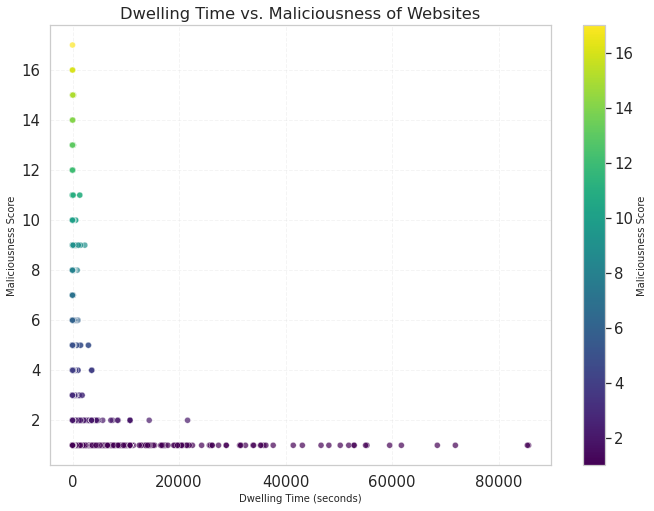

In [14]:
# plot
_scale = 0.8
_aspect_ratio = (12, 9)
figsize = tuple(k * _scale for k in _aspect_ratio)
_, ax = plt.subplots(figsize=figsize)


winsorized_mal_mins = winsorize(df_mal_visits["duration"], limits=(0.0, 0.01))

# Scatter plot with Seaborn using hue for color gradient
sc = sns.scatterplot(x=df_mal_visits["duration"], y=df_mal_visits['malicious'], 
                     hue=df_mal_visits['malicious'], palette='viridis', alpha=0.7, ax=ax, legend=False)

# Add colorbar separately using Matplotlib
norm = plt.Normalize(df_mal_visits['malicious'].min(), df_mal_visits['malicious'].max())
sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
sm.set_array([])  # Only needed for colorbar
plt.colorbar(sm, ax=ax, label='Maliciousness Score')

# Set labels and title
plt.xlabel("Dwelling Time (seconds)")
plt.ylabel("Maliciousness Score")
plt.title("Dwelling Time vs. Maliciousness of Websites")
plt.grid(True, linestyle="--", alpha=0.2)
# ax.set_xlim(-5, 450)
plt.tight_layout()

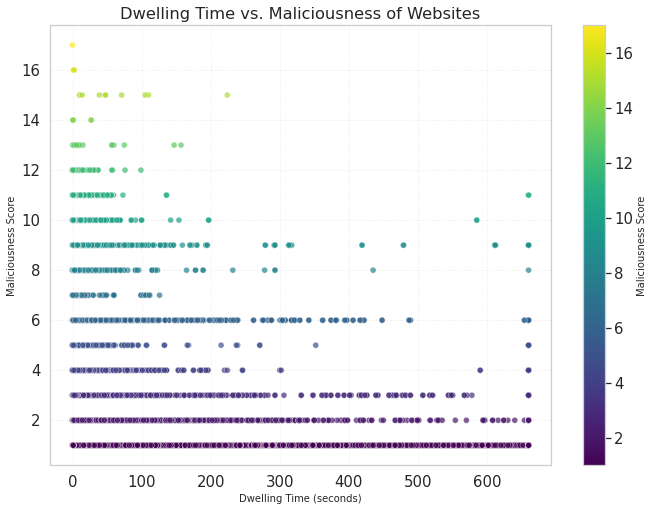

In [15]:
# plot
_scale = 0.8
_aspect_ratio = (12, 9)
figsize = tuple(k * _scale for k in _aspect_ratio)
_, ax = plt.subplots(figsize=figsize)

winsorized_mal_mins = winsorize(df_mal_visits["duration"], limits=(0.0, 0.01))

# Scatter plot with Seaborn using hue for color gradient
sc = sns.scatterplot(x=winsorized_mal_mins, y=df_mal_visits['malicious'], 
                     hue=df_mal_visits['malicious'], palette='viridis', alpha=0.7, ax=ax, legend=False)

# Add colorbar separately using Matplotlib
norm = plt.Normalize(df_mal_visits['malicious'].min(), df_mal_visits['malicious'].max())
sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
sm.set_array([])  # Only needed for colorbar
plt.colorbar(sm, ax=ax, label='Maliciousness Score')

# Set labels and title
plt.xlabel("Dwelling Time (seconds)")
plt.ylabel("Maliciousness Score")
plt.title("Dwelling Time vs. Maliciousness of Websites")
plt.grid(True, linestyle="--", alpha=0.2)
# ax.set_xlim(-5, 450)
plt.tight_layout()